# Curriculum

### Ways to work with Big Data:

- Do as much of the data manipulation as you can in Spark

- Use Spark to take a random sampling of the data and work with that smaller sample in pandas, which is great, but b/c all the data is in Spark, we may be missing some of it in our investigation

- Aggregate (groupBy) the data using Spark, then transfer that to pandas and work with it there.  One of the obstacles here is that we may lose data when aggregating


In [1]:
import warnings
warnings.filterwarnings("ignore")

import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from wrangle import wrangle_311

spark = pyspark.sql.SparkSession.builder.getOrCreate()

df = wrangle_311(spark)

print("\ndf shape: (%d, %d)\n" % (df.count(), len(df.columns)))

df.show(1, vertical=True)

[wrangle.py] reading case.csv
[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features
[wrangle.py] joining departments

df shape: (841704, 20)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                

**^^Took some time, for sure.  Exploring like this will take all day.**

### Working with all the Data in Spark

**Question: How many open and closed cases are there?**

In [2]:
df.groupby("case_status").count().show()

# "group all the cases by 'case_status' and show me the counts"

+-----------+------+
|case_status| count|
+-----------+------+
|       Open| 18110|
|     Closed|823594|
+-----------+------+



**Question: What's the average amount of time a case is open?**

In [3]:
df.groupby("case_status").agg(mean("case_lifetime")).show()

# "group all the cases by 'case_status', group THOSE (aggregate) by the average amount  
# of time in a 'case_lifetime', and show it to me.

+-----------+------------------+
|case_status|avg(case_lifetime)|
+-----------+------------------+
|       Open| 82.87338487023744|
|     Closed| 9.108407461102653|
+-----------+------------------+



### Remember to AGGREGATE WITH SPARK, VISUALIZE WITH PANDAS!

**Question: What does the case lifetime look like for each department?**

Text(0.5, 0, 'Number of Cases')

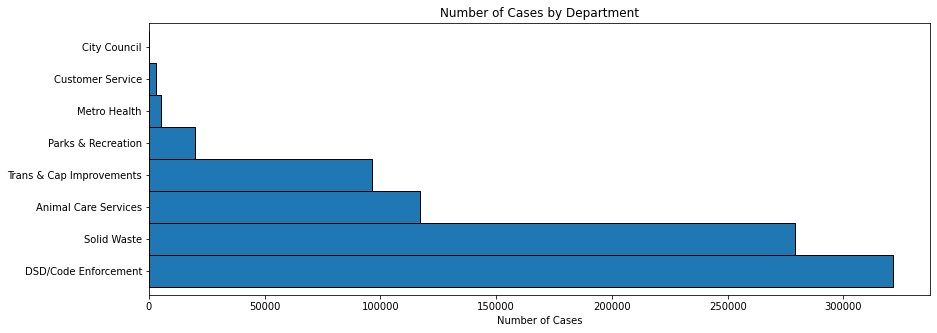

In [4]:
# First, aggregate with Spark
(
df.groupBy("department").count()
# then, pass the info over to pandas
.toPandas()
# set the pandas df index to be department
.set_index("department")["count"]
# set the df index to 'department' with the 'count' values
.sort_values(ascending=False)
# sort the values in descending order
.plot.barh(width=1, edgecolor="black", figsize=(14, 5))
) 
# making a horizontal barplot with those details

plt.title("Number of Cases by Department")
plt.ylabel("")
plt.xlabel("Number of Cases")

**^^DSD/Code Enforcement has the most cases**

Text(0.5, 1.0, 'Avg Case Lifetime By Department')

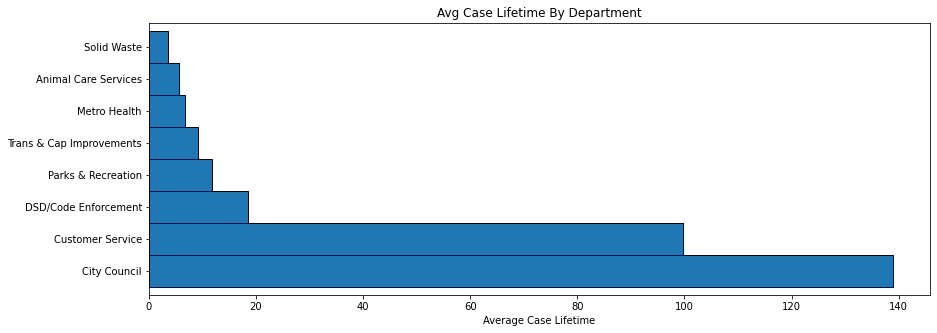

In [7]:
# Now that we have the number of cases per department, let's look at their lifetimes:

(
df.groupBy("department")
# group by all the departments
.agg(mean("case_lifetime").alias("avg_case_lifetime"))
# aggregate the data 'case_lifetime' and call it 'avg_case_lifetime' for easier reading

# now pass this info to pandas
.toPandas()
.set_index("department")
.avg_case_lifetime.sort_values(ascending=False)
.plot.barh(width=1, edgecolor="black", figsize=(14, 5))
)

plt.xlabel("Average Case Lifetime")
plt.ylabel("")
plt.title("Avg Case Lifetime By Department")

**^^So to answer our question, while DSD has the most (highest count) of cases, City Council has the longest average case lifetime.**

**Question: What is the average case lifetime by department for both open and closed cases?**

- NB: Here we will be using a pivot table.  Pivot tables are quick and powerful representations of our data, therefor *know what we're looking for before we start creating it.*  Otherwise, it could lead us down the wrong path.

In [10]:
# Aggregate with Spark

(
df.groupBy("department")
.pivot("case_status")
.agg(round(mean("case_lifetime"), 2))
# aggregate the data by the mean 'case_lifetime' to the nearest 2 sigfigs
.orderBy("Closed")
.show(truncate=False)
)

+------------------------+------+------+
|department              |Closed|Open  |
+------------------------+------+------+
|Solid Waste             |3.4   |16.45 |
|Animal Care Services    |5.51  |21.36 |
|Metro Health            |6.82  |4.64  |
|Trans & Cap Improvements|8.0   |54.39 |
|Parks & Recreation      |10.66 |64.72 |
|DSD/Code Enforcement    |15.65 |91.56 |
|City Council            |29.25 |154.07|
|Customer Service        |48.94 |172.94|
+------------------------+------+------+



**^^What this is showing us is that Solid Waste has the lowest average case lifetime to 'Close' status.**

### Use SAMPLES for Exploration using the '.sample( )' method

In [11]:
sample = df.sample(fraction=0.01, seed=13).toPandas()

# 'fraction' is a keyword that tells Spark how much of the data to use for the sample

# takes 1% of all the Spark data and sends it to pandas

print("Shape: ", sample.shape)

sample.head()

Shape:  (8357, 20)


,case_id,case_opened_date,case_closed_date,case_due_date,case_late,num_days_late,case_closed,service_request_type,SLA_days,case_status,source_id,request_address,council_district,num_weeks_late,zipcode,case_age,days_to_closed,case_lifetime,department,dept_subject_to_SLA
0,1014127348,2018-01-01 07:05:00,2018-01-02 15:33:00,2018-01-17 08:30:00,False,-14.706007,True,Front Or Side Yard Parking,16.058646,Closed,svcCRMSS,"834 BARREL POINT, San Antonio, 78251",004,-2.100858,78251,219,1.0,1,DSD/Code Enforcement,True
1,1014127499,2018-01-01 13:18:00,2018-02-04 12:16:00,2018-01-06 13:18:00,True,28.957257,True,Animal Neglect,5.000000,Closed,ns16326,"717 ALBERT ST, San Antonio, 78207",001,4.136751,78207,219,34.0,34,Animal Care Services,True
2,1014127512,2018-01-01 13:45:00,2018-01-09 09:58:00,2018-03-07 08:30:00,False,-56.938229,True,Overgrown Yard/Trash,64.781146,Closed,svcCRMSS,RAINBOW DR and CLOUDHAVEN DR,010,-8.134033,,219,8.0,8,DSD/Code Enforcement,True
3,1014127595,2018-01-01 15:21:00,2018-01-01 15:56:00,2018-03-28 08:30:00,False,-85.690104,True,Signal Timing Modification,85.714537,Closed,139344,EB IH 10 and MARTIN LUTHER,002,-12.241443,,219,0.0,0,Trans & Cap Improvements,True
4,1014127618,2018-01-01 15:52:00,2018-01-01 20:08:00,2020-09-26 15:52:00,False,-998.822014,True,Stray Animal,999.000000,Closed,139344,"407 ZARZAMORA N, San Antonio, 78207",005,-142.688859,78207,219,0.0,0,Animal Care Services,True


**^^From the shape of the sample, we see there are 8,357 rows across 20 columns of data.  This is MUCH easier for pandas to read and thus, do our visualizations.**

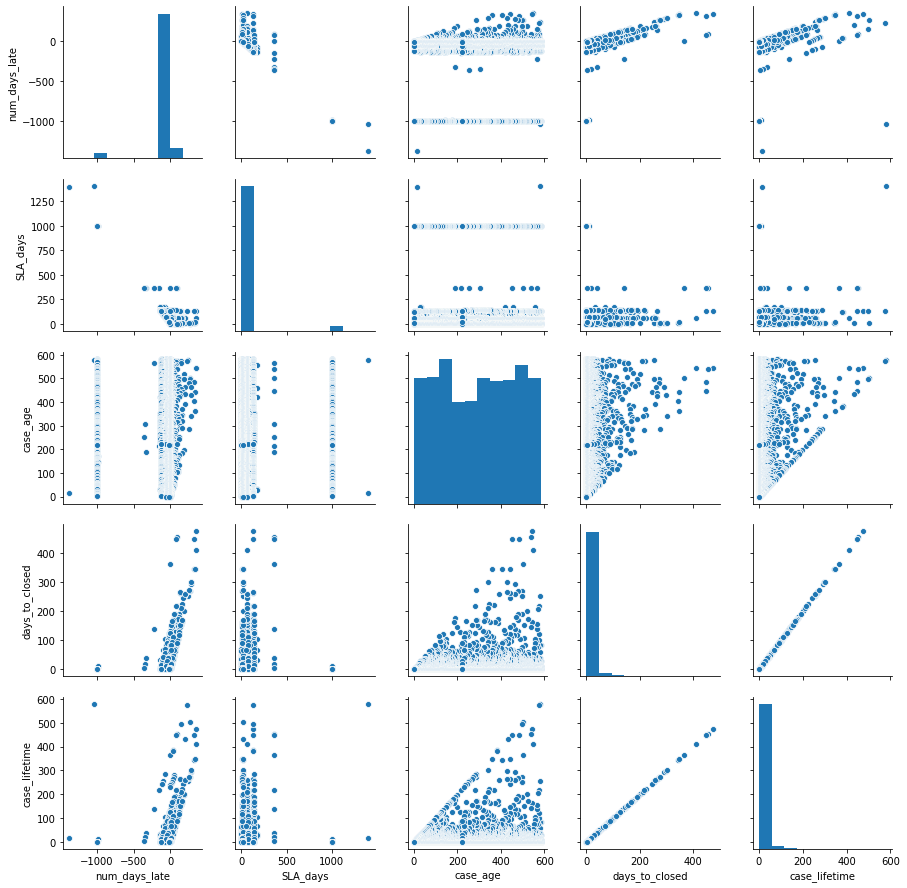

In [14]:
numeric_cols = [
    "num_days_late", 
    "SLA_days", 
    "case_age",
    "days_to_closed", 
    "case_lifetime",
]

sns.pairplot(sample[numeric_cols])

**^^We see that there is direct correlation (r=1) between 'days_to_closed' and 'case_lifetime.'  So, let's take a closer look at one of them, 'case_lifetime:'**

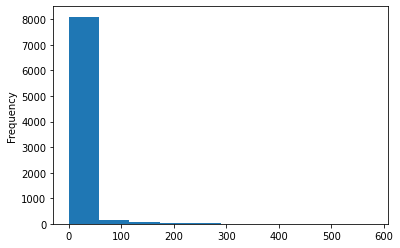

In [16]:
sample.case_lifetime.plot.hist()

**^^A few outliers, but most of the data is close to 0.  Bin them to get more info.**

In [17]:
pd.cut(sample.case_lifetime, 4).value_counts().sort_index()

# "Use 'pd.cut' to break the 'case_lifetime' sample into 4 bins, sort and index them
# by their 'value_counts()'."

(-0.579, 144.75]    8269
(144.75, 289.5]       69
(289.5, 434.25]       11
(434.25, 579.0]        8
Name: case_lifetime, dtype: int64

**^^Still, this doesn't tell me much, other than numerically represent the histogram above.  So, define custom bins:**

In [20]:
# in the call to 'pd.cut(),' we add right=False so that the behavior of pd.cut()
# aligns with the behavior of np.histogram, which is what matplotlib uses 
# when it actually builds a histogram.

# custom bins of varying width:

bins = [0, 1, 2, 5, 15, 1000]

print(pd.cut(sample.case_lifetime, bins, right=False).value_counts().sort_index())

# "print the number of values in the 'sample_case' bins, and sort by counts"


[0, 1)        2388
[1, 2)        1711
[2, 5)        1431
[5, 15)       1452
[15, 1000)    1375
Name: case_lifetime, dtype: int64


**^^There are 2,388 values in bins 0 and 1, 1,711 in bins 1 and 2, 1,431 in bins 2 and 5, etc.**

Text(0.5, 1.0, 'Overall Case Lifetime')

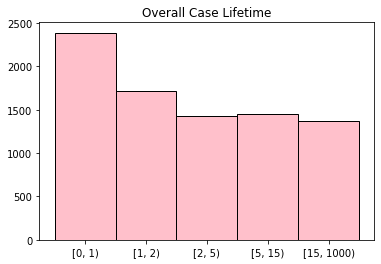

In [31]:
pd.cut(
sample.case_lifetime, bins, right=False).value_counts().sort_index().plot.bar(width=1, edgecolor="black", color="pink")

plt.xticks(rotation=0)
plt.title("Overall Case Lifetime")

**^^Much more detail here.  Instead of that single spike in the earlier histogram, we see it spread out now over 5 bins.  It's like we zoomed in on the one bar, and can now better see the distribution of cases.**

- Now to check the variation in lifetime distributions for just closed cases:

In [35]:
closed_cases = sample.query("case_closed")

# spark sql query 

open_cases = sample.query("not case_closed")

# spark sql query

(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

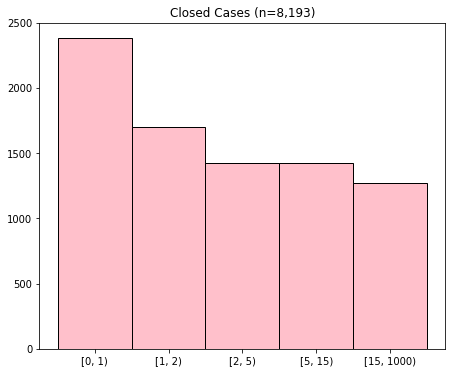

In [36]:
plt.figure(figsize=(16, 6))

plt.subplot(121)

(
pd.cut(closed_cases.case_lifetime, bins=bins, right=False).value_counts()
    .sort_index().plot.bar(width=1, edgecolor="black", color="pink", ax=plt.gca())
)

# .gca = "get current axis", and it makes sure to use the axis I assigned on the subplot (121)

plt.title("Closed Cases (n={:,})".format(closed_cases.shape[0]))
plt.xticks(rotation=0)


(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

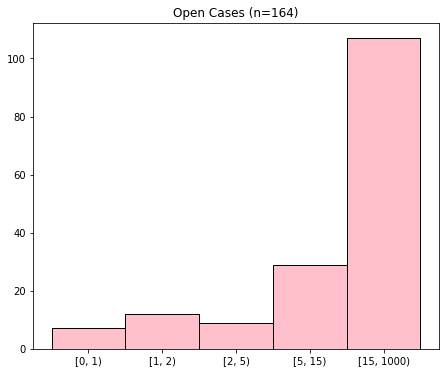

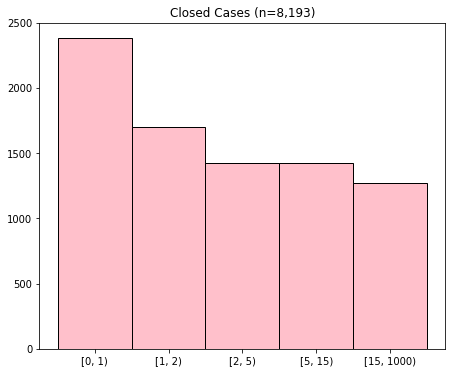

In [37]:
plt.figure(figsize=(16, 6))

plt.subplot(122)

(
pd.cut(open_cases.case_lifetime, bins=bins, right=False).value_counts()
    .sort_index().plot.bar(width=1, edgecolor="black", color="pink", ax=plt.gca())
)

# .gca = "get current axis", and it makes sure to use the axis I assigned on the subplot (122)

plt.title("Open Cases (n={:,})".format(open_cases.shape[0]))
plt.xticks(rotation=0)

plt.figure(figsize=(16, 6))

plt.subplot(121)

(
pd.cut(closed_cases.case_lifetime, bins=bins, right=False).value_counts()
    .sort_index().plot.bar(width=1, edgecolor="black", color="pink", ax=plt.gca())
)

# .gca = "get current axis", and it makes sure to use the axis I assigned on the subplot (121)

plt.title("Closed Cases (n={:,})".format(closed_cases.shape[0]))
plt.xticks(rotation=0)



### Exploring Aggregated Results

- for this example, we will be counting the number of cases closed and opened on each date, and then exploring the resulting time series dataset

- a time series dataset tells us that it's data over some period of time

In [53]:

cases_by_day = df.select("department", 
                        date_format("case_opened_date", "yyyy-MM-dd").alias("case_opened_date"),
                        date_format("case_closed_date", "yyyy-MM-dd").alias("case_closed_date"),
                        )
# "select" 'department' from the df, 
# format the 'case_opened' and 'case_closed' dates to 'yyyy-MM-dd', 
# rename each of them with these aliases, and 
# assign them to the variable 'cases_by_day'

cases_by_day.show(5)

+--------------------+----------------+----------------+
|          department|case_opened_date|case_closed_date|
+--------------------+----------------+----------------+
|Animal Care Services|      2018-01-01|      2018-01-01|
|Trans & Cap Impro...|      2018-01-01|      2018-01-03|
|Trans & Cap Impro...|      2018-01-01|      2018-01-02|
|DSD/Code Enforcement|      2018-01-01|      2018-01-02|
|Animal Care Services|      2018-01-01|      2018-01-01|
+--------------------+----------------+----------------+
only showing top 5 rows



**^^Number of TOTAL cases opened and closed each day**

**For the number of cases OPENED each day:**

In [57]:
cases_opened_by_day = (
    cases_by_day
    .groupby("case_opened_date")
    .count()
    .na.drop()
    .sort("case_opened_date")
    .toPandas()
    .assign(case_opened_date = lambda df: pd.to_datetime(df.case_opened_date))
    .set_index("case_opened_date")
    ["count"]
)
    
cases_opened_by_day.name = 'cases_opened'

In [60]:
cases_closed_by_day = (
    cases_by_day
    .groupby("case_closed_date")
    .count()
    .na.drop()
    .sort("case_closed_date")
    .toPandas()
    .assign(case_closed_date = lambda df: pd.to_datetime(df.case_closed_date))
    .set_index("case_closed_date")
    ["count"]
)
    
cases_closed_by_day.name = "cases_closed"


In [61]:
# Now throw these two df's into a single df using 'concat':

ts = pd.concat([cases_opened_by_day, cases_closed_by_day], axis=1)

# 'ts' is short for 'time series'

ts.head(10)

,cases_opened,cases_closed
2017-01-01,155,67
2017-01-02,1397,385
2017-01-03,1760,734
2017-01-04,1613,1206
2017-01-05,1791,1173
2017-01-06,1538,1025
2017-01-07,562,696
2017-01-08,250,154
2017-01-09,1861,1027
2017-01-10,1959,1419


**^^Shows us how many cases were opened and how many cases were closed on each of those dates from 2012**


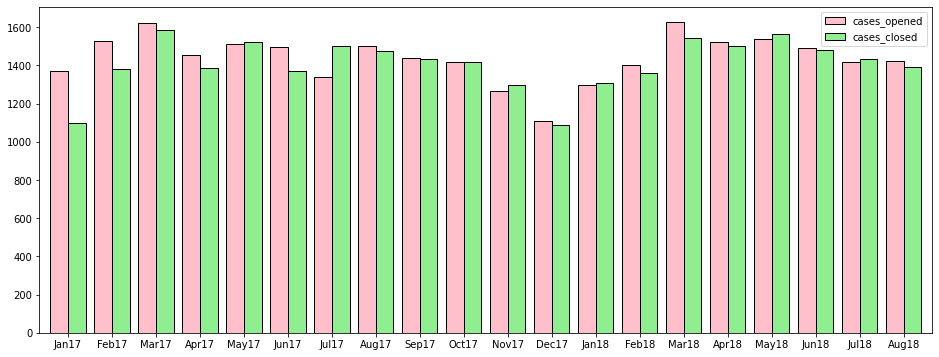

In [64]:
# Resample our original sample

ts.resample("M").mean().plot.bar(
    figsize=(16, 6), width=0.8, ec="black", color=["pink", "lightgreen"])

# we are 'resampling' our time series ('ts') by the mean numbers per month('M')
# in the cells above, we are sampling 'ts' by the day

# pretty x-axis labels

ticks, labels = plt.xticks()
labels = pd.to_datetime([l.get_text() for l in labels]).strftime("%b%y")

plt.xticks(ticks, labels, rotation=0)
None